Running convergence test with PML width 0.1...

Convergence results
     N          h         L2_rel         L2_abs     rate
    16 6.6667e-02   2.297717e-02   1.419519e-02    2.233
    32 3.2258e-02   4.543966e-03   2.881490e-03    2.228
    64 1.5873e-02   9.361113e-04   5.814508e-04    2.010
   128 7.8740e-03   2.287405e-04   1.406519e-04    1.718
   256 3.9216e-03   6.905833e-05   4.260478e-05    2.042
   512 1.9569e-03   1.669792e-05   1.031861e-05      nan

Average observed rate: 2.05


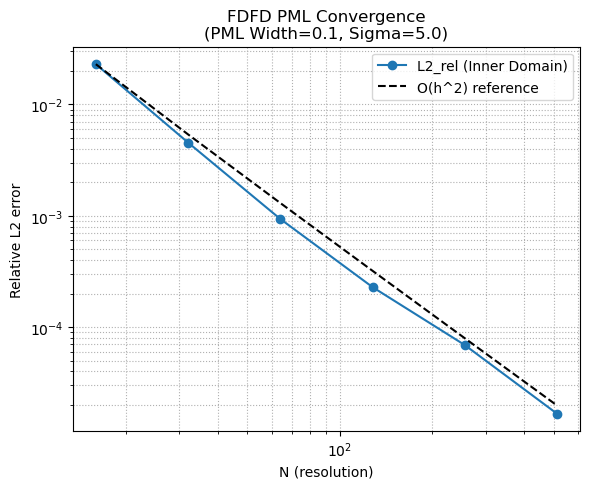

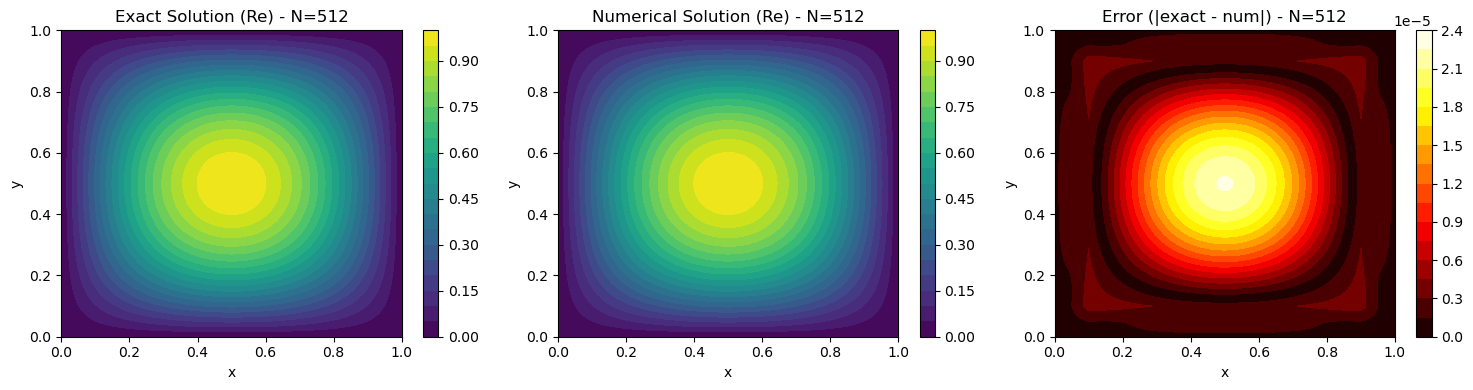

In [4]:
"""
Convergence test for the 2D Helmholtz FDFD solver with PML.

Geometry : Unit square [0, 1] x [0, 1]
PML      : Absorbing layers on the boundaries (thickness d_pml)
PDE      : (∇_s · ∇_s + k0^2 n^2) u = f
           where ∇_s is the gradient in stretched coordinates.
MMS      : u(x, y) = sin(pi x) * sin(pi y)
           The source term f is computed analytically to include PML effects.

We verify convergence (expected order 2) only in the interior region.
"""
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt

# PML parameters
PML_WIDTH = 0.1  # Thickness of the PML layer
SIGMA_MAX = 5.0   # Maximum absorption coefficient in the PML
P_ORDER = 2       # Order

def s_coordinate(u, L_min, L_max, d_pml, sigma_max, p_order, k0):
    """Computes the stretching factor s(u) and its derivative ds/du."""
    # Coordinates relative to PML interfaces
    dist_left = (L_min + d_pml) - u
    dist_right = u - (L_max - d_pml)
    
    # Masks for the regions
    in_pml_left = dist_left > 0
    in_pml_right = dist_right > 0
    
    sigma = np.zeros_like(u, dtype=complex)
    dsigma_du = np.zeros_like(u, dtype=complex)
    
    # Profile sigma(x) = sigma_max * (dist / d)^p
    if np.any(in_pml_left):
        d = dist_left[in_pml_left]
        sigma[in_pml_left] = sigma_max * (d / d_pml)**p_order
        dsigma_du[in_pml_left] = -sigma_max * p_order * (d**(p_order-1)) / (d_pml**p_order) 

    if np.any(in_pml_right):
        d = dist_right[in_pml_right]
        sigma[in_pml_right] = sigma_max * (d / d_pml)**p_order
        dsigma_du[in_pml_right] = sigma_max * p_order * (d**(p_order-1)) / (d_pml**p_order)

    # s(u) = 1 + 1j * sigma(u) / k0
    s = 1.0 + 1j * sigma / k0
    ds = 1j * dsigma_du / k0
    
    return s, ds


def build_pml_matrix(nx, ny, k0, n_val, hx, hy, x_nodes, y_nodes):
    sx_nodes, _ = s_coordinate(x_nodes, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)
    sy_nodes, _ = s_coordinate(y_nodes, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)

    x_half = x_nodes[:-1] + hx/2
    y_half = y_nodes[:-1] + hy/2
    
    sx_half, _ = s_coordinate(x_half, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)
    sy_half, _ = s_coordinate(y_half, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)

    def build_1d_diff_op(n, h, s_nodes, s_half):

        diags_main = []
        diags_upper = []
        diags_lower = []
        
        for i in range(1, n-1):
            si = s_nodes[i]
            s_plus = s_half[i]
            s_minus = s_half[i-1]
            
            # Coeffs
            c_plus = 1.0 / (h*h * si * s_plus)
            c_minus = 1.0 / (h*h * si * s_minus)
            c_main = -(c_plus + c_minus)
            
            diags_main.append(c_main)
            if i < n-2: diags_upper.append(c_plus)
            if i > 1:   diags_lower.append(c_minus)
            
        data = [diags_lower, diags_main, diags_upper]
        offsets = [-1, 0, 1]
        return sp.diags(data, offsets, shape=(n-2, n-2), format="csr")

    Dx = build_1d_diff_op(nx, hx, sx_nodes, sx_half)
    Dy = build_1d_diff_op(ny, hy, sy_nodes, sy_half)
    
    Ix = sp.eye(nx - 2, format="csr")
    Iy = sp.eye(ny - 2, format="csr")

    # Stretched Laplacian
    Lap_s = sp.kron(Iy, Dx) + sp.kron(Dy, Ix)
    
    # Final operator
    A = Lap_s + (k0**2 * n_val**2) * sp.eye((nx - 2) * (ny - 2), format="csr")
    return A


def get_pml_rhs(x_mesh, y_mesh, k0, n_val):
    pi = np.pi
    u = np.sin(pi * x_mesh) * np.sin(pi * y_mesh)
    
    # Derivatives
    ux  = pi * np.cos(pi * x_mesh) * np.sin(pi * y_mesh)
    uxx = -pi**2 * u
    
    uy  = pi * np.sin(pi * x_mesh) * np.cos(pi * y_mesh)
    uyy = -pi**2 * u
    
    # Stretching factors
    sx, dsx = s_coordinate(x_mesh, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)
    sy, dsy = s_coordinate(y_mesh, 0.0, 1.0, PML_WIDTH, SIGMA_MAX, P_ORDER, k0)
    
    op_x_u = (1.0 / sx**2) * uxx - (dsx / sx**3) * ux
    op_y_u = (1.0 / sy**2) * uyy - (dsy / sy**3) * uy
    
    # Total source term
    f = op_x_u + op_y_u + (k0**2 * n_val**2) * u
    return f, u


def run_convergence_pml(resolutions, k0=2 * np.pi, n_val=1.0):
    results = []
    
    # Define valid region for error computation
    valid_mask_min = PML_WIDTH
    valid_mask_max = 1.0 - PML_WIDTH

    for N in resolutions:
        nx = ny = N
        hx = 1.0 / (nx - 1)
        hy = 1.0 / (ny - 1)

        x = np.linspace(0.0, 1.0, nx)
        y = np.linspace(0.0, 1.0, ny)
        X, Y = np.meshgrid(x, y, indexing="ij") # meshgrid (nx, ny)

        f_rhs_full, u_exact_full = get_pml_rhs(X, Y, k0, n_val)

        f_int = f_rhs_full[1:-1, 1:-1].reshape(-1)

        A = build_pml_matrix(nx, ny, k0, n_val, hx, hy, x, y)
        u_int = spl.spsolve(A, f_int)

        u_num = np.zeros((nx, ny), dtype=complex)
        u_num[1:-1, 1:-1] = u_int.reshape((nx - 2, ny - 2))


        # Compute error only in the physical region (outside PML)
        # Create a boolean mask
        mask_x = (x >= valid_mask_min) & (x <= valid_mask_max)
        mask_y = (y >= valid_mask_min) & (y <= valid_mask_max)
        mask_2d = np.outer(mask_x, mask_y)
        
        # Extract valid points
        err = np.abs(u_num - u_exact_full)
        
        # L2 norm on the physical region (without PML)
        err_phy = err[mask_2d]
        ref_phy = np.abs(u_exact_full)[mask_2d]
        
        l2_abs = np.sqrt(np.mean(err_phy ** 2))
        l2_ref = np.sqrt(np.mean(ref_phy ** 2))
        l2_rel = l2_abs / l2_ref

        results.append({
            "N": N,
            "hx": hx,
            "l2_rel": l2_rel,
            "l2_abs": l2_abs,
            "u_num": u_num,
            "u_exact": u_exact_full
        })
    return results


def compute_rates(results):
    rates = []
    for i in range(len(results) - 1):
        h1 = results[i]["hx"]
        h2 = results[i + 1]["hx"]
        e1 = results[i]["l2_rel"]
        e2 = results[i + 1]["l2_rel"]
        rate = np.log(e1 / e2) / np.log(h1 / h2)
        rates.append(rate)
    return rates


def print_table(results):
    print(f"\nConvergence results")
    print(f"{'N':>6} {'h':>10} {'L2_rel':>14} {'L2_abs':>14} {'rate':>8}")
    rates = compute_rates(results)
    for i, res in enumerate(results):
        rate = rates[i] if i < len(rates) else np.nan
        print(f"{res['N']:6d} {res['hx']:10.4e} {res['l2_rel']:14.6e} {res['l2_abs']:14.6e} {rate:8.3f}")


def plot_results(results):
    Ns = np.array([r['N'] for r in results], dtype=float)
    hs = np.array([r['hx'] for r in results], dtype=float)
    errs = np.array([r['l2_rel'] for r in results], dtype=float)

    # Asymptotic line C*h^2
    C = errs[0] / (hs[0] ** 2)
    asym_errs = C * (hs ** 2)

    plt.figure(figsize=(6, 5))
    
    plt.loglog(Ns, errs, 'o-', label='L2_rel (Inner Domain)')
    plt.loglog(Ns, asym_errs, 'k--', label='O(h^2) reference')
    plt.xlabel('N (resolution)')
    plt.ylabel('Relative L2 error')
    plt.title(f'FDFD PML Convergence\n(PML Width={PML_WIDTH}, Sigma={SIGMA_MAX})')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.tight_layout()
    plt.savefig('fdfd_convergence_pml.pdf', bbox_inches='tight')
    plt.show()

    # Plot exact, numerical, and error for the finest resolution
    res_finest = results[-1]
    u_exact = res_finest['u_exact']
    u_num = res_finest['u_num']
    err = u_exact - u_num
    N = res_finest['N']
    x = np.linspace(0.0, 1.0, N)
    y = np.linspace(0.0, 1.0, N)
    X, Y = np.meshgrid(x, y, indexing='ij')

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].contourf(X, Y, np.real(u_exact), levels=20, cmap='viridis')
    axes[0].set_title(f'Exact Solution (Re) - N={N}')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].contourf(X, Y, np.real(u_num), levels=20, cmap='viridis')
    axes[1].set_title(f'Numerical Solution (Re) - N={N}')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].contourf(X, Y, np.abs(err), levels=20, cmap='hot')
    axes[2].set_title(f'Error (|exact - num|) - N={N}')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.savefig('fdfd_solution_error.pdf', bbox_inches='tight')
    plt.show()

def main():
    resolutions = [2**i for i in range(4, 10)]  # From 16 to 512
    k0 = 2 * np.pi      
    n_val = 1.0         

    print(f"Running convergence test with PML width {PML_WIDTH}...")
    results = run_convergence_pml(resolutions, k0=k0, n_val=n_val)
    print_table(results)
    
    avg_rate = np.nanmean(compute_rates(results))
    print(f"\nAverage observed rate: {avg_rate:.2f}")
    
    plot_results(results)

if __name__ == "__main__":
    main()